In [1]:
%load_ext autoreload
%autoreload 2
import sys
if '..' not in sys.path: sys.path.append("..")

# Segmentation and boundary-box regression

In [2]:
from src.utils.preprocess import tensor2numpy, image2axial,mask_threshold, preprocess_image, normalize
from src.utils import preprocess
from src.utils import plot
from src.utils.utils import split_custom_filename
from src.classifier.agent import Agent
from src.cam import CAM_TYPES, CAM
from src import segmentation
import nibabel as nib
import itertools

import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt

In [3]:
# Load models
trainer = Agent('resnet50', checkpoint_path="/var/metrics/codetests/logs/tb/resnet50/20210427002927/version_1/checkpoints/epoch=49-step=3699.ckpt")
trainer.load_model()
#trainer.run()
model = trainer.model
dataset = trainer.dataloader
cam_extractor = CAM(CAM_TYPES.SmoothGradCAMpp.value, model)

# Load example image
filename= '../data/SPM_categorised/AIH/CN/CN_ADNI_0443.nii'
#filename = '../data/SPM_categorised/AIH/AD/AD_ADNI_2491.nii'
#filename = '../data/SPM_categorised/AIH/AD/AD_ADNI_2526.nii'
class_label = split_custom_filename(filename,'/')[4]
test_image = normalize(image2axial(nib.load(filename).get_fdata()))

***Defined dataloader:***
Data directory: data/SPM_categorised/Amira/
Dataset sizes - Training: 444 Validation: 112
KFold: Enabled - Fold: 1/5

Loading model from /var/metrics/codetests/logs/tb/resnet50/20210427002927/version_1/checkpoints/epoch=49-step=3699.ckpt (checkpoint)..
Architecture [ResNet] was created
***Defined hyperparameters:***
"arch":                {'name': 'resnet50', 'args': {'num_channels': 1, 'num_classes': 3}}
"checkpoint_path":     None
"class_weights":       tensor([1.1935, 0.9250, 0.9250])
"hp_metrics":          ['loss/train', 'loss/val', 'accuracy/val', 'auc/val', 'specificity/val', 'sensitivity/val']
"loss":                {'type': 'CrossEntropyLoss', 'args': {'weight': True}}
"optimizer":           {'type': 'Adam', 'args': {'lr': 0.001, 'betas': [0.9, 0.999], 'weight_decay': 1e-05, 'amsgrad': True}}
"roi_hparams":         {'enable': False, 'output_shape': [40, 40, 40], 'boundary_boxes': []}
"weight_distribution": normal


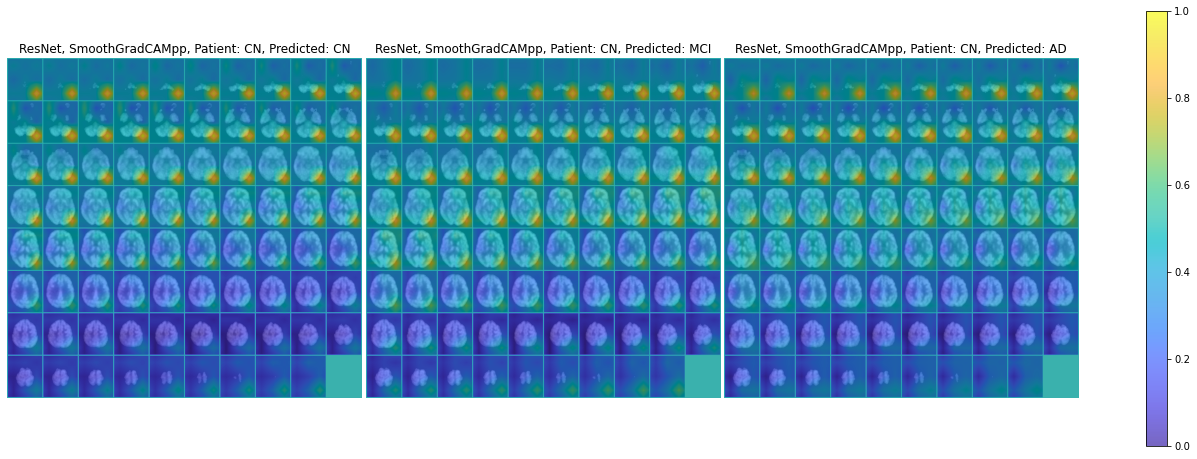

In [4]:
class_scores, class_idx = cam_extractor.evaluate(test_image)
grid_image, grid_mask = cam_extractor.grid_class(class_scores, [0,1,2], test_image,pad_value=0, max_num_slices=None)
masked_image = preprocess_image(cam_extractor.activation_map(class_idx, class_scores))
cam_extractor.plot(class_scores, [0,1,2],test_image, max_num_slices=None, class_label=class_label);

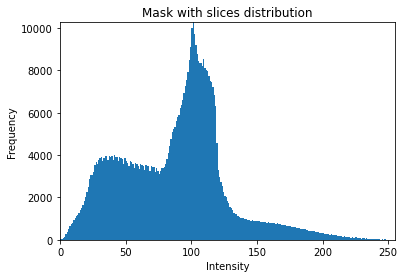

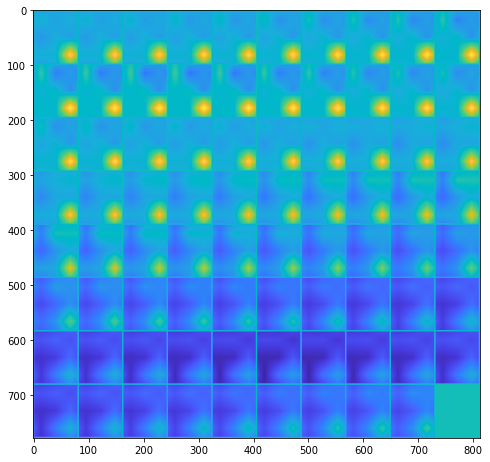

In [5]:
# Only check the distribution from each image! This looks a lot better!
sliced_masks = preprocess_image(cam_extractor.activation_map(0, class_scores))

# Remove background since this give faulty ideas otherwise
#sliced_masks[test_image == 0] = 0
#segmentation.intensity_distribution(sliced_masks[30].flatten(),title="Mask with slices distribution")
plot.intensity_distribution(sliced_masks.ravel(),title="Mask with slices distribution")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()

plot.imshow(preprocess.to_grid(sliced_masks))

# Extract Segmentation and boundary boxes

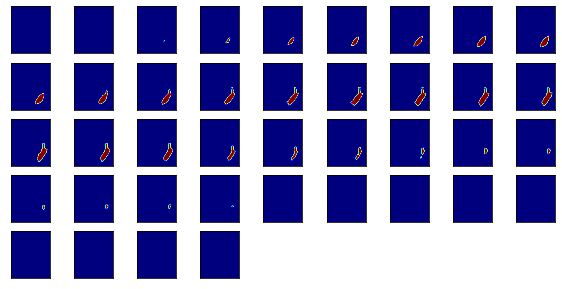

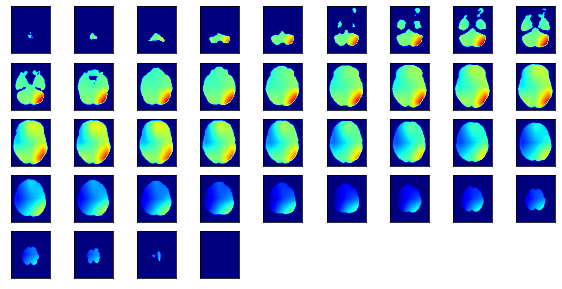

In [6]:
#features = segmentation.sequential_processing(test_image.copy(), sliced_masks.copy())
inner = segmentation.feature_extraction(cam_extractor, upper_bound=0.95,lower_bound=0.5,func='extract')
derp = inner(torch.from_numpy(test_image),1)
plot.display_3D(derp[0]);
plot.display_3D(derp[1]);

In [7]:
inner = segmentation.feature_extraction(cam_extractor, upper_bound=0.8,lower_bound=0.5,func='features')
features = inner((1,"Something", torch.from_numpy(test_image), 0,0))
features

{'image': 'Something',
 'patient_class': 0,
 'observe_class': 0,
 'probability_class': 2,
 'bbox_area': [350037],
 'mean_intensity': [124.5649747352194],
 'bbox': [(5, 3, 74, 92, 0, 57)],
 'upper_bound': 114.0,
 'lower_bound': 93.0,
 'use_quantile_bounds': True,
 'score': array([-0.03429252])}

# RoIAlign

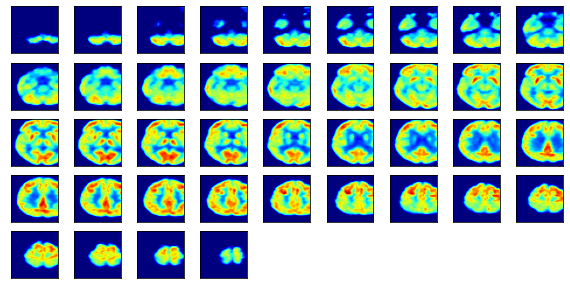

In [8]:
derp = segmentation.roi_align(test_image, features['bbox'], displayed=True)

## Extract all regions

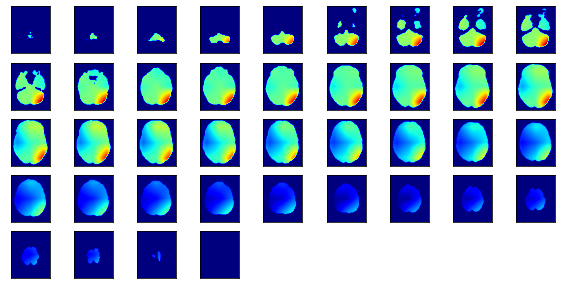

In [9]:
tmp_slices = sliced_masks.copy()
tmp_slices[test_image == 0] = 0
plot.display_3D(tmp_slices);

In [10]:
import pandas as pd
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor
from src.utils.utils import create_directory
import os

CALCULATE_BBOX = True
BBOX_FILENAME = r'../logs/bbox/resnet50/bbox_2021-04-22 17:08:06.333885.csv'

if CALCULATE_BBOX:

    
    fileset = dataset.val_dataloader().dataset

    content = itertools.product(enumerate(fileset),[0,1,2])
    extraction_method = segmentation.feature_extraction(cam_extractor, upper_bound=0.95,lower_bound=0.5,)

    with ThreadPoolExecutor(max_workers=10) as executor:
        results = executor.map(extraction_method,((i, fileset.data[i].rsplit("/",1)[1],image, patient_class, observe_class) for (i, (image, patient_class)), observe_class in content))
    #derp = [extraction_method((i, fileset.data[i].rsplit("/",1)[1], image, patient_class, observe_class)) for (i, (image, patient_class)), observe_class in content]
    bboxes_dict = list(results)
    # Convert data to dataframe
    
    bboxes_df = pd.DataFrame(bboxes_dict)
    bboxes_df.rename(columns = {'index' : 'image', 'bbox':'bbox'}, inplace = True)
    bboxes_df['bbox_count'] = bboxes_df['bbox'].str.len()
    bboxes_df = bboxes_df[bboxes_df['bbox_count']>0]
    bboxes_df = bboxes_df.apply(pd.Series.explode)
    bboxes_df['bbox'] = bboxes_df['bbox'].apply(lambda row: list(row))
    
    bboxes_df.reset_index(inplace = True)
    bboxes_df.rename(columns = {'index' : 'Image_class'}, inplace = True)
    bboxes_df.head(20)

    # Sort data
    bboxes_df.sort_values('score',ascending=False,inplace=True)
    
    # Save to logs
    
    now = datetime.now()
    name = f"../logs/bbox/{model._hparams['arch']['name']}/bbox_{now}.csv"
    os.makedirs(f"../logs/bbox/{model._hparams['arch']['name']}", exist_ok=True)
    bboxes_df.to_csv(name,index=False,header=True)

else:
    bboxes_df = pd.read_csv(BBOX_FILENAME, dtype={'patient_class':int, 'observe_class':int,'probability_class':int,'bbox_count':int})
    bboxes_df['bbox'] = segmentation.column_to_np(segmentation.column_to_tuple(bboxes_df['bbox']))

In [11]:
bboxes_df.head(40)

,Image_class,image,patient_class,observe_class,probability_class,bbox_area,mean_intensity,bbox,upper_bound,lower_bound,use_quantile_bounds,score,bbox_count
33,9,AD_ADNI_2975.nii,2,0,2,4,189.0,"[65, 29, 66, 31, 20, 22]",188.0,149.0,True,0.833654,3
14,5,AD_ADNI_2866.nii,2,2,2,64,188.0,"[61, 26, 65, 30, 17, 21]",187.0,148.0,True,0.833117,3
11,4,AD_ADNI_2866.nii,2,1,2,64,188.0,"[61, 26, 65, 30, 17, 21]",187.0,148.0,True,0.833117,3
243,143,MCI_ADNI_1999.nii,1,2,2,11440,200.550462,"[11, 56, 33, 82, 5, 25]",189.0,149.0,True,0.830995,2
8,3,AD_ADNI_2866.nii,2,0,2,1,188.0,"[61, 26, 62, 27, 17, 18]",187.0,147.0,True,0.830061,3
303,179,MCI_ADNI_1434.nii,1,2,2,270,190.685714,"[55, 15, 61, 24, 15, 20]",188.0,149.0,True,0.827201,3
471,281,CN_ADNI_0510.nii,0,2,2,2304,193.372781,"[52, 7, 64, 23, 9, 21]",189.0,149.0,True,0.826368,3
264,159,MCI_ADNI_1859.nii,1,0,2,48,221.375,"[19, 16, 23, 20, 16, 19]",216.0,119.0,True,0.826139,2
554,335,CN_ADNI_0508.nii,0,2,2,11880,200.738164,"[11, 56, 33, 83, 6, 26]",189.0,149.0,True,0.825752,2
352,209,MCI_ADNI_1714.nii,1,2,2,96,189.916667,"[56, 21, 60, 25, 13, 19]",188.0,149.0,True,0.8234,3


# Check distributions for validating clusters

<AxesSubplot:>

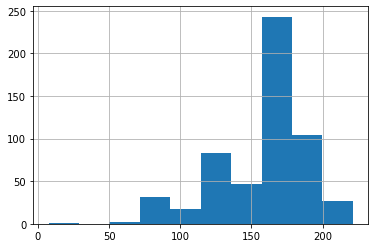

In [12]:
bboxes_df.mean_intensity.hist() # x: snitt intensitet, y: Frekvens

<AxesSubplot:>

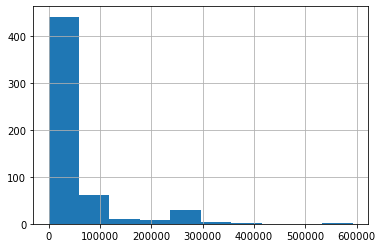

In [13]:
bboxes_df.bbox_area.hist() # x:storlek i pixlar, y: Frekvens

In [14]:
def plot_bbox_category_scatter(bboxes_df, upper_limit=None, lower_limit=None):
    _bboxes_df = bboxes_df.copy()
    if upper_limit:
        _bboxes_df = _bboxes_df.loc[_bboxes_df['bbox_area']<=upper_limit]
    if lower_limit:
        _bboxes_df = _bboxes_df.loc[_bboxes_df['bbox_area']>=lower_limit]
    
    cn_bboxes = _bboxes_df.loc[(bboxes_df['observe_class'] == 0) & (_bboxes_df['patient_class'] == 0) ]
    mci_bboxes = _bboxes_df.loc[(bboxes_df['observe_class'] == 1) & (_bboxes_df['patient_class'] == 1)]
    ad_bboxes = _bboxes_df.loc[(bboxes_df['observe_class'] == 2) & (_bboxes_df['patient_class'] == 2)]

    fig = plt.figure()
    plt.title("Relation between area and intensity")
    plt.xlabel("Intensity")
    plt.ylabel("Area")
    plt.scatter(cn_bboxes.mean_intensity,cn_bboxes.bbox_area,color='blue',label='CN',alpha=0.5)
    plt.scatter(mci_bboxes.mean_intensity,mci_bboxes.bbox_area,color='green',label='MCI',alpha=0.5)
    plt.scatter(ad_bboxes.mean_intensity,ad_bboxes.bbox_area,color='purple',label='AD',alpha=0.5)
    #plt.plot((100,240),(0,400000), color='red')
    plt.legend(loc='upper left')
    plt.show()
    return cn_bboxes,mci_bboxes,ad_bboxes

In [15]:
bboxes_df.loc[(bboxes_df['bbox_area'] > 20000) & (bboxes_df['bbox_area'] < 170000)]

,Image_class,image,patient_class,observe_class,probability_class,bbox_area,mean_intensity,bbox,upper_bound,lower_bound,use_quantile_bounds,score,bbox_count
244,143,MCI_ADNI_1999.nii,1,2,2,30380,192.283481,"[42, 30, 73, 58, 14, 49]",189.0,149.0,True,0.79905,2
555,335,CN_ADNI_0508.nii,0,2,2,38760,190.016591,"[44, 24, 74, 58, 13, 51]",189.0,149.0,True,0.780415,2
10,4,AD_ADNI_2866.nii,2,1,2,32256,189.326241,"[46, 26, 74, 58, 13, 49]",187.0,148.0,True,0.77882,3
13,5,AD_ADNI_2866.nii,2,2,2,32256,189.326241,"[46, 26, 74, 58, 13, 49]",187.0,148.0,True,0.77882,3
378,224,MCI_ADNI_1751.nii,1,2,2,25346,172.242385,"[47, 58, 70, 87, 5, 43]",157.0,98.0,True,0.769715,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,244,CN_ADNI_0479.nii,0,1,2,61992,122.063056,"[19, 55, 60, 91, 19, 61]",83.0,8.0,True,0.262048,4
412,243,CN_ADNI_0479.nii,0,0,2,61992,122.063056,"[19, 55, 60, 91, 19, 61]",83.0,8.0,True,0.262048,4
465,276,CN_ADNI_0468.nii,0,0,2,148238,68.431956,"[37, 3, 75, 86, 3, 50]",75.0,14.0,True,0.106392,1
467,278,CN_ADNI_0468.nii,0,2,2,148238,68.431956,"[37, 3, 75, 86, 3, 50]",75.0,14.0,True,0.106392,1


# Plot relation between area and intensity

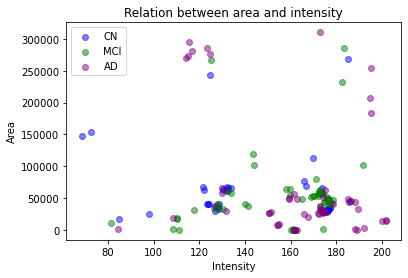

In [16]:
cn_bboxes, mci_bboxes, ad_bboxes = plot_bbox_category_scatter(bboxes_df, lower_limit=100)

# Plot suggested bounding boxes for each class

In [17]:
# show df for AD
ad_bboxes

,Image_class,image,patient_class,observe_class,probability_class,bbox_area,mean_intensity,bbox,upper_bound,lower_bound,use_quantile_bounds,score,bbox_count
60,32,AD_ADNI_2622.nii,2,2,2,3672,191.84873,"[52, 6, 64, 24, 8, 25]",188.0,148.0,True,0.815108,3
12,5,AD_ADNI_2866.nii,2,2,2,13662,200.098428,"[10, 57, 33, 84, 5, 27]",187.0,148.0,True,0.810182,3
31,8,AD_ADNI_2900.nii,2,2,2,112,189.115385,"[57, 19, 61, 23, 16, 23]",188.0,148.0,True,0.803378,4
29,8,AD_ADNI_2900.nii,2,2,2,2002,188.077634,"[50, 5, 63, 19, 9, 20]",188.0,148.0,True,0.80019,4
59,32,AD_ADNI_2622.nii,2,2,2,13662,201.612417,"[10, 57, 33, 84, 4, 26]",188.0,148.0,True,0.798259,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,56,AD_ADNI_2706.nii,2,2,2,284832,123.118608,"[3, 2, 75, 88, 14, 60]",140.0,63.0,True,0.010104,1
43,17,AD_ADNI_2497.nii,2,2,2,273700,114.902177,"[4, 2, 74, 87, 14, 60]",140.0,63.0,True,0.009277,1
49,23,AD_ADNI_2718.nii,2,2,2,270480,114.269075,"[4, 3, 74, 87, 14, 60]",140.0,63.0,True,0.006426,1
46,20,AD_ADNI_2454.nii,2,2,2,281160,116.662662,"[4, 3, 75, 91, 14, 59]",140.0,63.0,True,-0.007565,1


In [18]:
# show df for MCI
mci_bboxes

,Image_class,image,patient_class,observe_class,probability_class,bbox_area,mean_intensity,bbox,upper_bound,lower_bound,use_quantile_bounds,score,bbox_count
284,172,MCI_ADNI_1668.nii,1,1,2,41325,176.904245,"[49, 59, 74, 88, 4, 61]",164.0,98.0,True,0.723592,1
342,205,MCI_ADNI_2005.nii,1,1,2,44175,174.331861,"[49, 56, 74, 87, 5, 62]",165.0,99.0,True,0.714325,1
324,193,MCI_ADNI_1492.nii,1,1,2,42336,177.024632,"[47, 59, 74, 87, 4, 60]",164.0,98.0,True,0.711889,1
265,160,MCI_ADNI_1859.nii,1,1,2,44460,176.742559,"[48, 57, 74, 87, 3, 60]",164.0,98.0,True,0.710535,1
256,154,MCI_ADNI_1862.nii,1,1,2,49248,176.235447,"[47, 56, 74, 88, 4, 61]",164.0,99.0,True,0.70723,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,121,MCI_ADNI_1465.nii,1,1,2,119416,143.356221,"[5, 45, 64, 91, 0, 44]",157.0,95.0,True,0.427382,3
235,136,MCI_ADNI_1741.nii,1,1,2,40014,127.50039,"[48, 51, 75, 90, 17, 55]",94.0,26.0,True,0.388634,2
250,148,MCI_ADNI_1529.nii,1,1,2,232028,182.441429,"[4, 2, 75, 78, 9, 52]",215.0,118.0,True,0.350284,1
396,232,MCI_ADNI_2984.nii,1,1,2,286230,183.389432,"[4, 3, 74, 90, 9, 56]",215.0,119.0,True,0.268829,1


In [19]:
# show df for CN
cn_bboxes

,Image_class,image,patient_class,observe_class,probability_class,bbox_area,mean_intensity,bbox,upper_bound,lower_bound,use_quantile_bounds,score,bbox_count
539,324,CN_ADNI_0534.nii,0,0,2,32625,175.551996,"[47, 59, 72, 88, 3, 48]",158.0,92.0,True,0.746581,1
509,306,CN_ADNI_0578.nii,0,0,2,28896,175.735558,"[47, 59, 71, 87, 5, 48]",158.0,92.0,True,0.746446,1
481,288,CN_ADNI_0517.nii,0,0,2,31900,176.302589,"[47, 59, 72, 88, 4, 48]",158.0,92.0,True,0.743945,1
492,294,CN_ADNI_0522.nii,0,0,2,30100,175.744529,"[47, 59, 72, 87, 5, 48]",158.0,92.0,True,0.740874,1
430,252,CN_ADNI_0525.nii,0,0,2,30912,176.164358,"[48, 59, 72, 87, 2, 48]",158.0,92.0,True,0.737837,1
443,264,CN_ADNI_0461.nii,0,0,2,31500,176.152909,"[47, 59, 72, 87, 3, 48]",158.0,92.0,True,0.736794,1
517,312,CN_ADNI_0473.nii,0,0,2,31900,176.380721,"[47, 59, 72, 88, 4, 48]",158.0,92.0,True,0.73361,1
543,327,CN_ADNI_0536.nii,0,0,2,34500,177.206501,"[48, 58, 73, 88, 3, 49]",158.0,92.0,True,0.732911,1
473,282,CN_ADNI_0625.nii,0,0,2,30960,176.469335,"[48, 58, 72, 88, 5, 48]",158.0,92.0,True,0.72518,1
512,309,CN_ADNI_0594.nii,0,0,2,33000,176.178503,"[47, 58, 72, 88, 3, 47]",158.0,92.0,True,0.713679,1


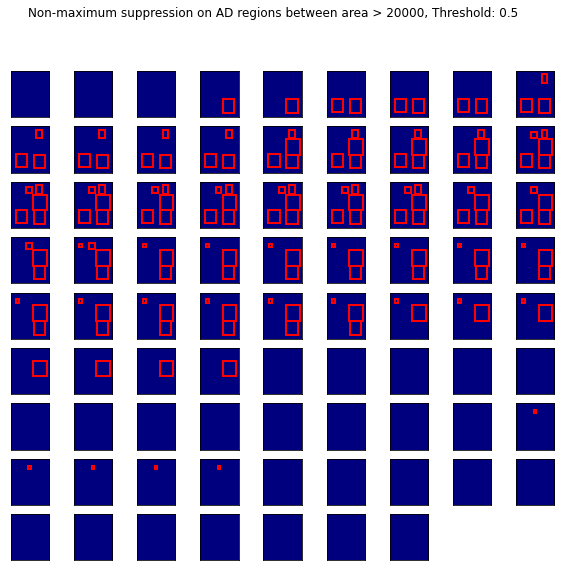

In [20]:
# Plot bbox for AD
ad_interesting, fig = segmentation.interesting_bbox(ad_bboxes[ad_bboxes['score']>0.5],th=0.0)
fig.suptitle("Non-maximum suppression on AD regions between area > 20000, Threshold: 0.5")
plt.show()

In [21]:
ad_interesting

tensor([[52.,  6., 64., 24.,  8., 25.],
        [10., 57., 33., 84.,  5., 27.],
        [46., 26., 74., 58., 13., 49.],
        [47., 58., 70., 86.,  3., 42.],
        [36., 14., 41., 20., 62., 67.],
        [11., 13., 17., 20., 28., 45.],
        [31., 11., 43., 23., 17., 29.]])

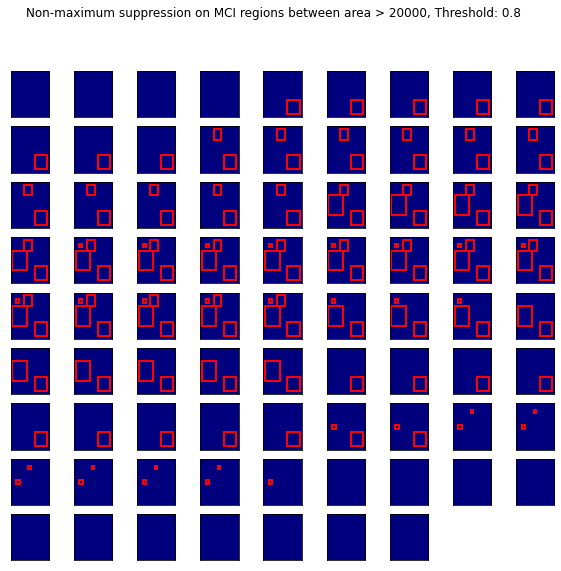

In [22]:
# Plot bbox for MCI
mci_interesting, fig = segmentation.interesting_bbox(mci_bboxes[mci_bboxes['score']>0.5], th=0.0)
fig.suptitle("Non-maximum suppression on MCI regions between area > 20000, Threshold: 0.8")
plt.show()

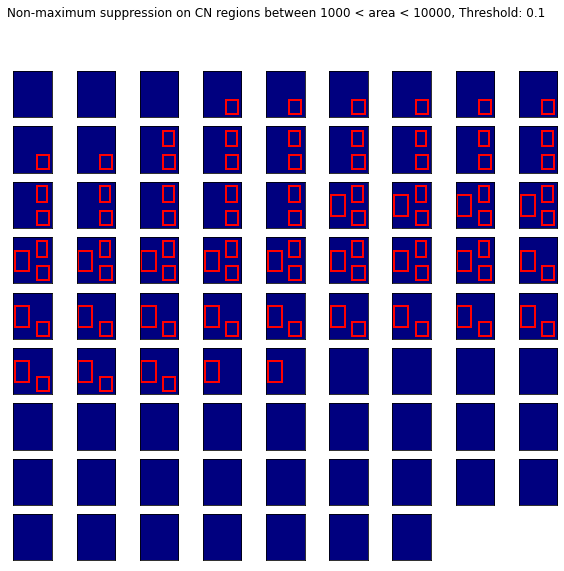

In [23]:
# Plot bbox for CN
#cn_interesting,fig = segmentation.plot_interesting_bbox(cn_bboxes[(cn_bboxes['bbox_area'] <10000) & (cn_bboxes['bbox_area'] >1000)], th=0.1)
cn_interesting,fig = segmentation.interesting_bbox(cn_bboxes[cn_bboxes['score']>0.5], th=0.0)

fig.suptitle("Non-maximum suppression on CN regions between 1000 < area < 10000, Threshold: 0.1")
plt.show()

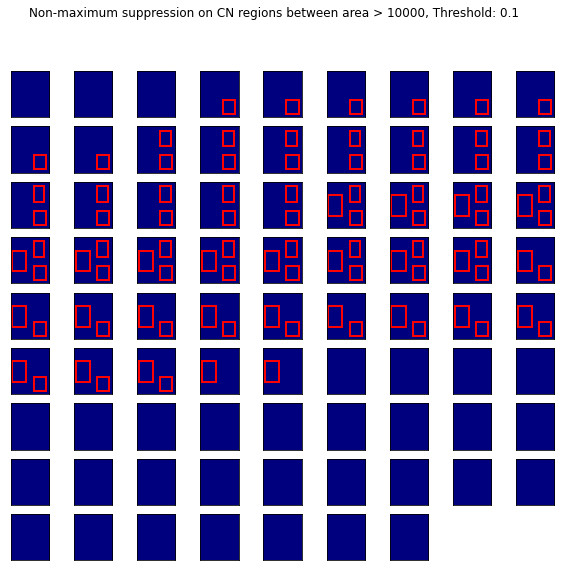

In [24]:
# Plot bbox for CN with another condition
cn_interesting2,fig = segmentation.interesting_bbox(cn_bboxes[cn_bboxes['score']>0.5], th=0.0)
fig.suptitle("Non-maximum suppression on CN regions between area > 10000, Threshold: 0.1")
plt.show()

In [25]:
def find_interesting_from_df(df_data, interesting_data):
    new_rows = df_data.apply(lambda row: row if list(row.bbox) in interesting_data.int().tolist() else 0, axis=1)
    return new_rows[new_rows['bbox'] != 0]

# Number of total boxes
print(ad_bboxes.shape[0])
print(mci_bboxes.shape[0])
print(cn_bboxes.shape[0])

61
62
40


In [26]:
find_interesting_from_df(ad_bboxes, ad_interesting)

,Image_class,image,patient_class,observe_class,probability_class,bbox_area,mean_intensity,bbox,upper_bound,lower_bound,use_quantile_bounds,score,bbox_count
60,32,AD_ADNI_2622.nii,2,2,2,3672,191.848730,"[52, 6, 64, 24, 8, 25]",188.0,148.0,True,0.815108,3
12,5,AD_ADNI_2866.nii,2,2,2,13662,200.098428,"[10, 57, 33, 84, 5, 27]",187.0,148.0,True,0.810182,3
13,5,AD_ADNI_2866.nii,2,2,2,32256,189.326241,"[46, 26, 74, 58, 13, 49]",187.0,148.0,True,0.778820,3
40,14,AD_ADNI_2509.nii,2,2,2,25116,172.313559,"[47, 58, 70, 86, 3, 42]",157.0,98.0,True,0.751710,1
192,116,AD_ADNI_2534.nii,2,2,2,150,161.590909,"[36, 14, 41, 20, 62, 67]",157.0,95.0,True,0.650020,4
190,116,AD_ADNI_2534.nii,2,2,2,714,161.761194,"[11, 13, 17, 20, 28, 45]",157.0,95.0,True,0.649068,4
95,53,AD_ADNI_2442.nii,2,2,2,1728,84.494403,"[31, 11, 43, 23, 17, 29]",90.0,56.0,True,0.604134,3


In [27]:
find_interesting_from_df(mci_bboxes, mci_interesting)

,Image_class,image,patient_class,observe_class,probability_class,bbox_area,mean_intensity,bbox,upper_bound,lower_bound,use_quantile_bounds,score,bbox_count
284,172,MCI_ADNI_1668.nii,1,1,2,41325,176.904245,"[49, 59, 74, 88, 4, 61]",164.0,98.0,True,0.723592,1
392,229,MCI_ADNI_2276.nii,1,1,2,180,159.894737,"[36, 14, 41, 20, 61, 67]",157.0,95.0,True,0.648935,4
391,229,MCI_ADNI_2276.nii,1,1,2,672,161.605364,"[11, 13, 17, 20, 28, 44]",157.0,95.0,True,0.648105,4
290,175,MCI_ADNI_1867.nii,1,1,2,672,160.756881,"[11, 13, 17, 20, 28, 44]",157.0,95.0,True,0.643691,4
277,166,MCI_ADNI_1536.nii,1,1,2,33210,173.015385,"[3, 27, 33, 68, 23, 50]",151.0,82.0,True,0.618431,2
365,217,MCI_ADNI_1474.nii,1,1,2,10208,81.358300,"[27, 5, 43, 27, 12, 41]",90.0,56.0,True,0.557327,3
306,181,MCI_ADNI_2160.nii,1,1,2,567,111.253012,"[11, 43, 18, 52, 59, 68]",110.0,34.0,True,0.508167,2


In [28]:
find_interesting_from_df(cn_bboxes, cn_interesting)

,Image_class,image,patient_class,observe_class,probability_class,bbox_area,mean_intensity,bbox,upper_bound,lower_bound,use_quantile_bounds,score,bbox_count
539,324,CN_ADNI_0534.nii,0,0,2,32625,175.551996,"[47, 59, 72, 88, 3, 48]",158.0,92.0,True,0.746581,1
549,330,CN_ADNI_0575.nii,0,0,2,33669,173.015868,"[3, 27, 32, 70, 23, 50]",151.0,82.0,True,0.623176,2
427,249,CN_ADNI_0616.nii,0,0,2,16896,84.930347,"[47, 8, 69, 40, 11, 35]",69.0,31.0,True,0.614914,1


In [29]:
print(f'AD: \n{ad_interesting.int().numpy()}\nMCI: \n{mci_interesting.int().numpy()}\nCN: \n{cn_interesting.int().numpy()}')

AD: 
[[52  6 64 24  8 25]
 [10 57 33 84  5 27]
 [46 26 74 58 13 49]
 [47 58 70 86  3 42]
 [36 14 41 20 62 67]
 [11 13 17 20 28 45]
 [31 11 43 23 17 29]]
MCI: 
[[49 59 74 88  4 61]
 [36 14 41 20 61 67]
 [11 13 17 20 28 44]
 [ 3 27 33 68 23 50]
 [27  5 43 27 12 41]
 [11 43 18 52 59 68]]
CN: 
[[47 59 72 88  3 48]
 [ 3 27 32 70 23 50]
 [47  8 69 40 11 35]]


In [30]:
# Create list of bbox that can be loaded.
merge_interesting_boxes = np.stack([*ad_interesting,*mci_interesting,*cn_interesting,*cn_interesting2])
merge_interesting_boxes

array([[52.,  6., 64., 24.,  8., 25.],
       [10., 57., 33., 84.,  5., 27.],
       [46., 26., 74., 58., 13., 49.],
       [47., 58., 70., 86.,  3., 42.],
       [36., 14., 41., 20., 62., 67.],
       [11., 13., 17., 20., 28., 45.],
       [31., 11., 43., 23., 17., 29.],
       [49., 59., 74., 88.,  4., 61.],
       [36., 14., 41., 20., 61., 67.],
       [11., 13., 17., 20., 28., 44.],
       [ 3., 27., 33., 68., 23., 50.],
       [27.,  5., 43., 27., 12., 41.],
       [11., 43., 18., 52., 59., 68.],
       [47., 59., 72., 88.,  3., 48.],
       [ 3., 27., 32., 70., 23., 50.],
       [47.,  8., 69., 40., 11., 35.],
       [47., 59., 72., 88.,  3., 48.],
       [ 3., 27., 32., 70., 23., 50.],
       [47.,  8., 69., 40., 11., 35.]], dtype=float32)

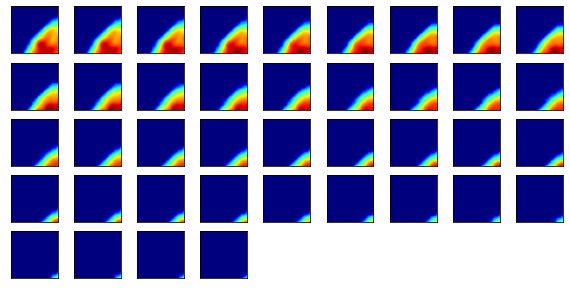

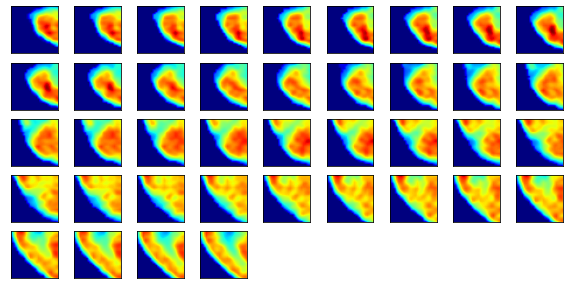

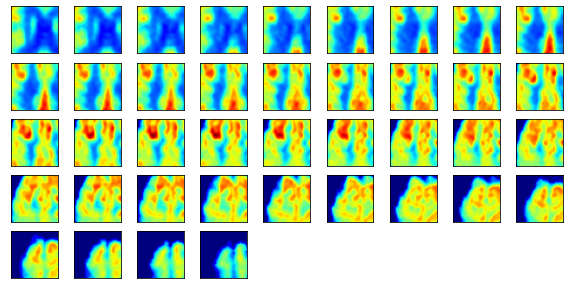

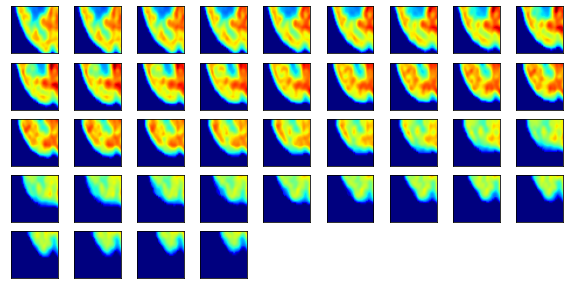

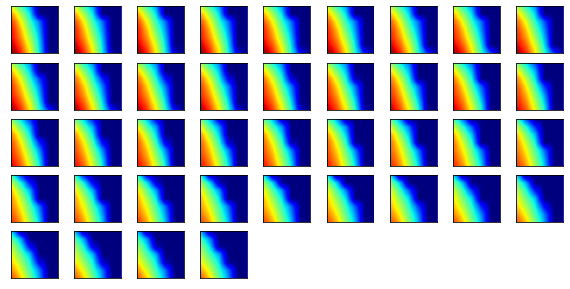

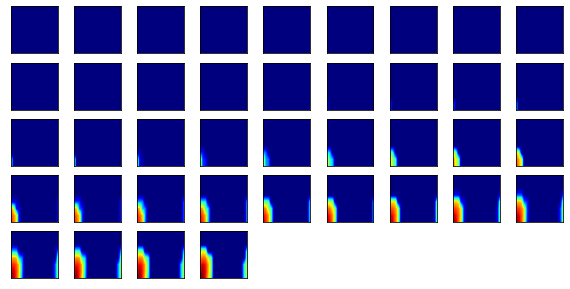

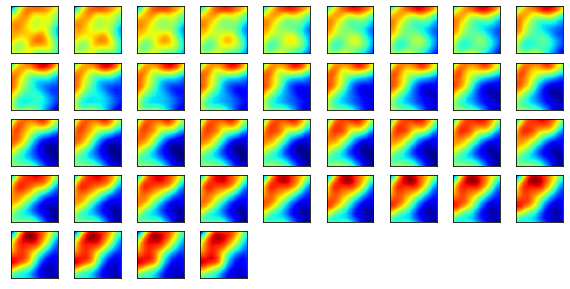

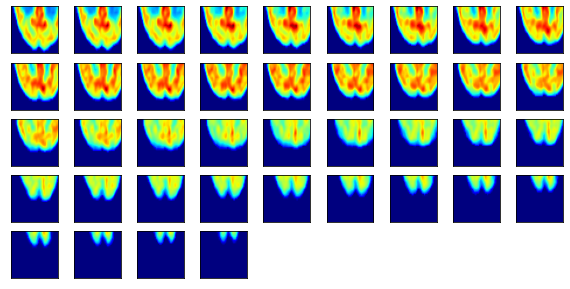

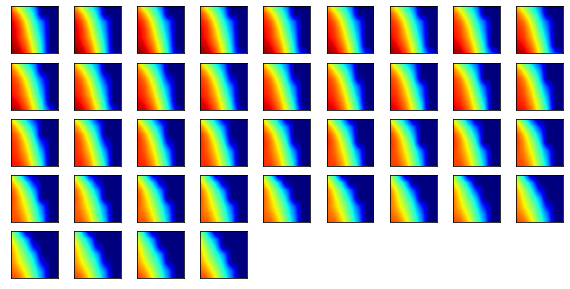

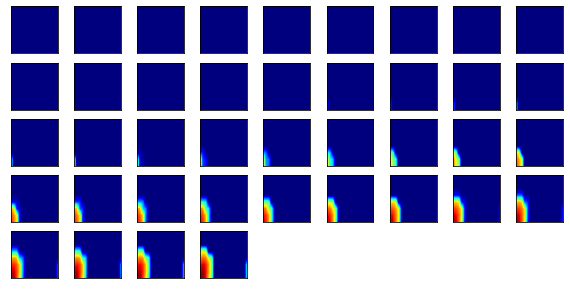

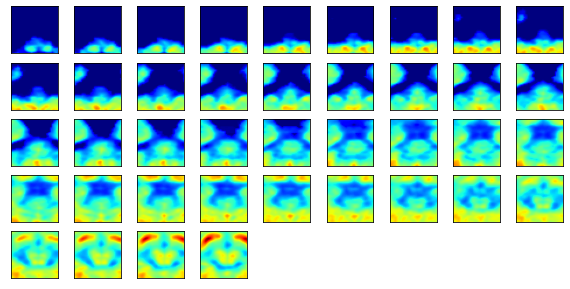

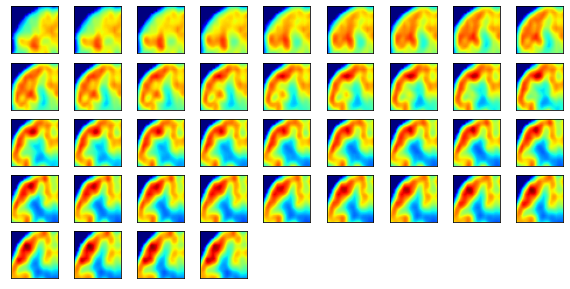

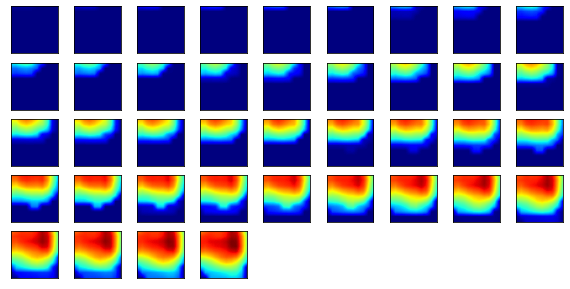

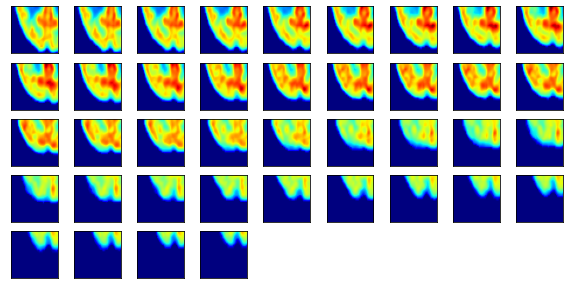

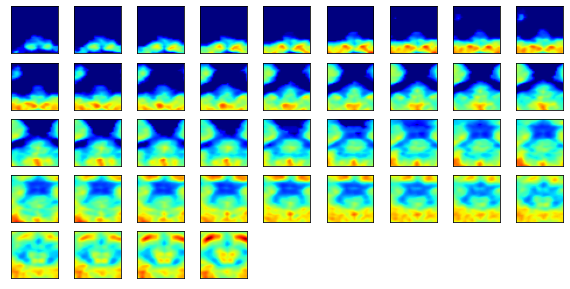

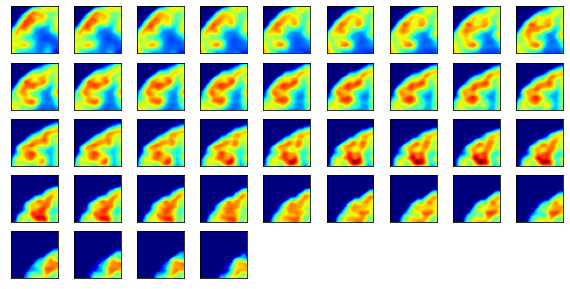

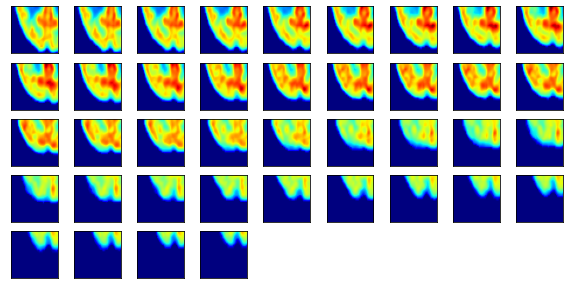

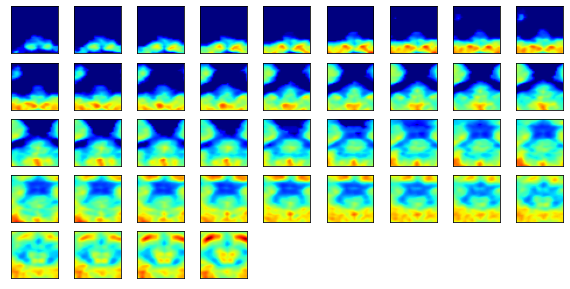

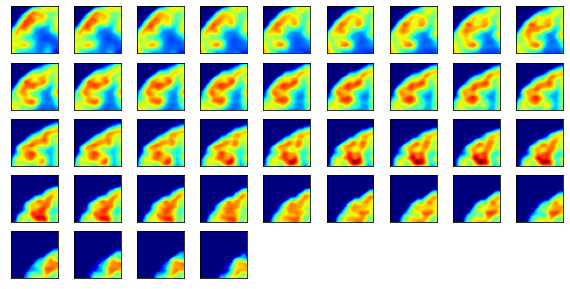

In [31]:
# Roi extraction
segmentation.roi_align(test_image, merge_interesting_boxes, displayed=True);

In [32]:
""" https://www.analyticsvidsort_index/blog/2020/08/selecting-the-right-bounding-box-using-non-max-suppression-with-implementation/
Step 1: Select the box with highest objectiveness score [Replace with intensity?] - Calculate with nms (package availible in segmentation)
Step 2: Then, compare the overlap (intersection over union) of this box with other boxes 
Step 3: Remove the bounding boxes with overlap (intersection over union) >50%
Step 4: Then, move to the next highest objectiveness score
Step 5: Finally, repeat steps 2-4
"""

' https://www.analyticsvidsort_index/blog/2020/08/selecting-the-right-bounding-box-using-non-max-suppression-with-implementation/\nStep 1: Select the box with highest objectiveness score [Replace with intensity?] - Calculate with nms (package availible in segmentation)\nStep 2: Then, compare the overlap (intersection over union) of this box with other boxes \nStep 3: Remove the bounding boxes with overlap (intersection over union) >50%\nStep 4: Then, move to the next highest objectiveness score\nStep 5: Finally, repeat steps 2-4\n'